In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse
from pathlib import Path
import re
import random
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Reading the BF data

In [ ]:
bf_path = '/content/drive/MyDrive/ALL_CLEAN_DEIDEN_NAME AND ECMO DATA(Sheet1) (1) (version 2).csv'
cols = ['ID','weight', 'study_height', 'age_days', 'bsa', 'Reason for ECMO']
df = pd.read_csv(bf_path, usecols=cols)

for col in ['weight', 'study_height', 'age_days', 'bsa']:
    s = pd.to_numeric(df[col], errors='coerce')
    mx = s.max(skipna=True)
    if pd.notna(mx) and mx != 0:
        df[col] = s / mx
    else:
        df[col] = s
print(df.head())

   ID  age_days    weight  study_height       bsa Reason for ECMO
0   1  0.018213  0.042214      0.344538  0.128389        cardiac 
1   2  0.072852  0.070000      0.431373  0.184992        cardiac 
2   3  0.793776  0.403571      0.896359  0.640295         cardiac
3   4  0.000287  0.022786      0.268908  0.083332         cardiac
4   5  0.000287  0.023571      0.285714  0.087365     respiratory


In [ ]:
diag_clean = (
    df['Reason for ECMO']
      .astype('string')
      .str.strip()
      .str.replace(r'\s+', ' ', regex=True)
      .fillna('Unknown')
)

codes, uniques = pd.factorize(diag_clean, sort=True)
df['Reason for ECMO'] = codes.astype('int64')
diagnosis_mapping = {cat: int(i) for i, cat in enumerate(uniques)}

# Peek
print(df.head())

   ID  age_days    weight  study_height       bsa  Reason for ECMO
0   1  0.018213  0.042214      0.344538  0.128389                2
1   2  0.072852  0.070000      0.431373  0.184992                2
2   3  0.793776  0.403571      0.896359  0.640295                2
3   4  0.000287  0.022786      0.268908  0.083332                2
4   5  0.000287  0.023571      0.285714  0.087365                3


In [ ]:
df.shape

(73, 6)

### No normalization!

In [ ]:
from pathlib import Path
import re, random, math, os
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# Config
# =========================
SPLIT_DIR = r"/content/drive/MyDrive/CD/patient_data_clean_nozero_181920212223_1800"
POS_PATIENTS = {1, 2, 16, 19, 21, 22, 25, 37, 39, 43, 44, 47, 50, 56, 58, 62, 65, 66, 73, 78}

BATCH_SIZE       = 3
EPOCHS           = 100
LR               = 1e-4
SEED             = 1

# =========================
# Repro
# =========================
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
for g in tf.config.list_physical_devices('GPU'):
    try: tf.config.experimental.set_memory_growth(g, True)
    except Exception: pass

# =========================
# Helpers
# =========================
PATIENT_NUM_RX = re.compile(r'^ID(\d+)')  # e.g., "ID76-2_..." -> 76

def patient_num_from_path(pathlike):
    stem = Path(pathlike).stem
    m = PATIENT_NUM_RX.match(stem)
    return int(m.group(1)) if m else None

def label_for_file(p: Path) -> int:
    pnum = patient_num_from_path(p)
    return 1 if (pnum is not None and pnum in POS_PATIENTS) else 0

# =========================
# Load pre-existing 4-feature DataFrame: df (must be in memory)
# Must contain column 'ID' + exactly 4 feature columns.
# =========================
feats_df = df.copy()  # <-- uses your in-memory DataFrame
if "ID" not in feats_df.columns:
    raise RuntimeError("Your features DataFrame must contain column 'ID'.")

FEAT_COLS = [c for c in feats_df.columns if c != "ID"]
#if len(FEAT_COLS) != 4:
#    raise RuntimeError(f"Expected exactly 4 feature columns besides 'ID', found {len(FEAT_COLS)}: {FEAT_COLS}")

# Clean and index by ID; drop rows with missing any of the 4 features
feats_df["ID"] = pd.to_numeric(feats_df["ID"], errors="coerce").astype("Int64")
feats_df = feats_df.dropna(subset=["ID"] + FEAT_COLS).copy()
feats_df["ID"] = feats_df["ID"].astype(int)

ID_TO_FEAT = {
    int(row["ID"]): row[FEAT_COLS].astype("float32").to_numpy()
    for _, row in feats_df.iterrows()
}
FEAT_DIM = len(FEAT_COLS)
print('FEAT_DIM =', FEAT_DIM)

# =========================
# List EEG files ONLY to define splits by patient ID (no EEG is loaded)
# =========================
split_dir = Path(SPLIT_DIR)
all_csvs = sorted(split_dir.glob("*.csv"))
if not all_csvs:
    raise FileNotFoundError(f"No CSV found in {SPLIT_DIR}")

# Map: id -> list of files for that patient
id_to_files = {}
for f in all_csvs:
    pid = patient_num_from_path(f)
    if pid is None:
        continue
    id_to_files.setdefault(pid, []).append(f)

all_ids = sorted(id_to_files.keys())

# Use only IDs that have the required 4 features
valid_ids = [pid for pid in all_ids if pid in ID_TO_FEAT]
if not valid_ids:
    raise RuntimeError("No overlapping patient IDs between files and the 4-feature table.")
if len(valid_ids) < len(all_ids):
    print(f"Dropping {len(all_ids)-len(valid_ids)} patient IDs without 4-feature rows.")

labels_all = np.array([1 if pid in POS_PATIENTS else 0 for pid in valid_ids], dtype=int)

print("Total valid IDs:", len(valid_ids),
      "| Pos IDs:", labels_all.sum(),
      "| Neg IDs:", (1 - labels_all).sum())

# =========================
# Data Sequence (tab-only)
# Each file becomes one sample with that patient's 4 features.
# =========================
class TabSequence(keras.utils.Sequence):
    def __init__(self, files, batch_size=BATCH_SIZE, shuffle=True):
        super().__init__()
        # Keep only files whose patient ID has 4 features
        self.files = [f for f in files if patient_num_from_path(f) in ID_TO_FEAT]
        self.batch_size = int(batch_size)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.files) / self.batch_size)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.files))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        idxs = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_files = [self.files[i] for i in idxs]
        B = len(batch_files)

        X_tab = np.empty((B, FEAT_DIM), dtype=np.float32)
        y     = np.empty((B,), dtype=np.int32)

        for i, f in enumerate(batch_files):
            pid = patient_num_from_path(f)
            X_tab[i] = ID_TO_FEAT[pid]      # (4,)
            y[i] = label_for_file(f)

        return {"tab_input": X_tab}, y

# =========================
# Tab-only Model: 4 -> 8 -> 8 -> 1
# =========================
def build_model(tab_dim=FEAT_DIM, lr=LR, dropout=0.2):
    tab_in = keras.Input(shape=(tab_dim,), name="tab_input")
    t = layers.Dense(8, activation="relu")(tab_in)
    t = layers.Dense(8, activation="relu")(t)
    t = layers.Dropout(dropout)(t)
    out = layers.Dense(1, activation="sigmoid")(t)

    model = keras.Model(inputs=tab_in, outputs=out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.BinaryAccuracy(name="acc"),
                 keras.metrics.AUC(name="auc")],
    )
    return model

# =========================
# 10-fold Cross-Validation by patient ID (stratified)
# =========================
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

fold_aucs = []
for fold_idx, (train_index, test_index) in enumerate(skf.split(valid_ids, labels_all), start=1):
    ids_train_full = [valid_ids[i] for i in train_index]
    ids_test       = [valid_ids[i] for i in test_index]

    # small validation split from training IDs (stratified, by ID)
    train_labels_full = np.array([1 if pid in POS_PATIENTS else 0 for pid in ids_train_full], dtype=int)
    ids_tr, ids_val = train_test_split(
        ids_train_full, test_size=0.10, random_state=SEED,
        stratify=train_labels_full
    )

    # Build file lists for this fold
    train_files = [f for pid in ids_tr  for f in id_to_files[pid]]
    val_files   = [f for pid in ids_val for f in id_to_files[pid]]
    test_files  = [f for pid in ids_test for f in id_to_files[pid]]

    print(f"\n--- Fold {fold_idx}/10 ---")
    def split_summary_by_ids(name, ids, files):
        ys = np.array([label_for_file(f) for f in files], dtype=int)
        print(f"{name:>6} | ids: {len(ids):4d} | files: {len(files):4d} | pos: {(ys==1).sum():4d} | neg: {(ys==0).sum():4d}")
    split_summary_by_ids("train", ids_tr,  train_files)
    split_summary_by_ids("val",   ids_val, val_files)
    split_summary_by_ids("test",  ids_test, test_files)

    # Generators
    train_gen = TabSequence(train_files, batch_size=BATCH_SIZE, shuffle=True)
    val_gen   = TabSequence(val_files,   batch_size=BATCH_SIZE, shuffle=False)

    # Model + training
    model = build_model()
    best_path = f"best_tab_only_fold{fold_idx}.h5"
    ckpt = keras.callbacks.ModelCheckpoint(
        best_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[ckpt],
        verbose=1,
    )

    # Evaluate on this fold's test set
    best_model = keras.models.load_model(best_path)

    test_files2 = [f for f in test_files if patient_num_from_path(f) in ID_TO_FEAT]
    X_tab_test = np.empty((len(test_files2), FEAT_DIM), dtype=np.float32)
    for i, f in enumerate(test_files2):
        X_tab_test[i] = ID_TO_FEAT[patient_num_from_path(f)]
    y_true = np.array([label_for_file(f) for f in test_files2], dtype=int)

    probs1 = best_model.predict({"tab_input": X_tab_test}, verbose=0).ravel().astype(float)
    try:
        auc = roc_auc_score(y_true, probs1)
    except ValueError:
        auc = float('nan')

    fold_aucs.append(float(auc))
    print(f"Fold {fold_idx} AUC: {auc:.4f}")

# =========================
# Results across folds
# =========================
print("\nAUCs per fold:", fold_aucs)
if len([a for a in fold_aucs if not np.isnan(a)]) > 0:
    print(f"Mean AUC: {np.nanmean(fold_aucs):.4f} ± {np.nanstd(fold_aucs):.4f}")

FEAT_DIM = 5
Total valid IDs: 44 | Pos IDs: 14 | Neg IDs: 30

--- Fold 1/10 ---
 train | ids:   35 | files:  904 | pos:  318 | neg:  586
   val | ids:    4 | files:   42 | pos:    1 | neg:   41
  test | ids:    5 | files:  254 | pos:   86 | neg:  168
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 5))']
  warnings.warn(msg)


287/302 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.4206 - auc: 0.4503 - loss: 0.7065
Epoch 1: val_loss improved from inf to 0.65956, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - acc: 0.4188 - auc: 0.4488 - loss: 0.7066 - val_acc: 0.6905 - val_auc: 1.0000 - val_loss: 0.6596
Epoch 2/100
289/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4586 - auc: 0.4124 - loss: 0.7008
Epoch 2: val_loss improved from 0.65956 to 0.64397, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.4621 - auc: 0.4140 - loss: 0.7005 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.6440
Epoch 3/100
289/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5967 - auc: 0.4540 - loss: 0.6867
Epoch 3: val_loss improved from 0.64397 to 0.62979, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.5964 - auc: 0.4544 - loss: 0.6866 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.6298
Epoch 4/100
283/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6167 - auc: 0.5482 - loss: 0.6706
Epoch 4: val_loss improved from 0.62979 to 0.60841, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6170 - auc: 0.5475 - loss: 0.6706 - val_acc: 0.9762 - val_auc: 0.6585 - val_loss: 0.6084
Epoch 5/100
282/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6074 - auc: 0.5246 - loss: 0.6669
Epoch 5: val_loss improved from 0.60841 to 0.58584, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6080 - auc: 0.5279 - loss: 0.6666 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.5858
Epoch 6/100
286/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6539 - auc: 0.6443 - loss: 0.6436
Epoch 6: val_loss improved from 0.58584 to 0.56592, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6526 - auc: 0.6416 - loss: 0.6442 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.5659
Epoch 7/100
289/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6248 - auc: 0.5897 - loss: 0.6570
Epoch 7: val_loss improved from 0.56592 to 0.54851, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6256 - auc: 0.5904 - loss: 0.6568 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.5485
Epoch 8/100
290/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6398 - auc: 0.5830 - loss: 0.6573
Epoch 8: val_loss improved from 0.54851 to 0.53370, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6403 - auc: 0.5840 - loss: 0.6568 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.5337
Epoch 9/100
284/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6569 - auc: 0.6351 - loss: 0.6410
Epoch 9: val_loss improved from 0.53370 to 0.52045, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6576 - auc: 0.6342 - loss: 0.6409 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.5204
Epoch 10/100
284/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6557 - auc: 0.6031 - loss: 0.6503
Epoch 10: val_loss improved from 0.52045 to 0.50825, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6567 - auc: 0.6045 - loss: 0.6494 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.5082
Epoch 11/100
281/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6560 - auc: 0.6276 - loss: 0.6429
Epoch 11: val_loss improved from 0.50825 to 0.49796, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6578 - auc: 0.6280 - loss: 0.6420 - val_acc: 0.9762 - val_auc: 0.0244 - val_loss: 0.4980
Epoch 12/100
297/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6894 - auc: 0.6899 - loss: 0.6130
Epoch 12: val_loss improved from 0.49796 to 0.48469, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6893 - auc: 0.6893 - loss: 0.6131 - val_acc: 0.9762 - val_auc: 0.0244 - val_loss: 0.4847
Epoch 13/100
279/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6627 - auc: 0.6519 - loss: 0.6322
Epoch 13: val_loss improved from 0.48469 to 0.47476, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6645 - auc: 0.6515 - loss: 0.6313 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.4748
Epoch 14/100
281/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6928 - auc: 0.6047 - loss: 0.6215
Epoch 14: val_loss improved from 0.47476 to 0.46765, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6928 - auc: 0.6055 - loss: 0.6214 - val_acc: 0.9762 - val_auc: 0.0244 - val_loss: 0.4677
Epoch 15/100
281/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6969 - auc: 0.5593 - loss: 0.6271
Epoch 15: val_loss improved from 0.46765 to 0.46576, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6961 - auc: 0.5633 - loss: 0.6270 - val_acc: 0.9762 - val_auc: 0.0244 - val_loss: 0.4658
Epoch 16/100
284/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7050 - auc: 0.6649 - loss: 0.6052
Epoch 16: val_loss improved from 0.46576 to 0.45894, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7042 - auc: 0.6639 - loss: 0.6058 - val_acc: 0.9762 - val_auc: 0.0244 - val_loss: 0.4589
Epoch 17/100
291/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6568 - auc: 0.6163 - loss: 0.6360
Epoch 17: val_loss improved from 0.45894 to 0.45414, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6579 - auc: 0.6169 - loss: 0.6352 - val_acc: 0.9762 - val_auc: 0.0244 - val_loss: 0.4541
Epoch 18/100
284/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7009 - auc: 0.6252 - loss: 0.6071
Epoch 18: val_loss improved from 0.45414 to 0.44972, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7005 - auc: 0.6245 - loss: 0.6076 - val_acc: 0.9762 - val_auc: 0.0244 - val_loss: 0.4497
Epoch 19/100
288/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7165 - auc: 0.5985 - loss: 0.6007
Epoch 19: val_loss improved from 0.44972 to 0.44908, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7152 - auc: 0.5995 - loss: 0.6014 - val_acc: 0.9762 - val_auc: 0.0244 - val_loss: 0.4491
Epoch 20/100
286/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7062 - auc: 0.6435 - loss: 0.6027
Epoch 20: val_loss improved from 0.44908 to 0.44437, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7056 - auc: 0.6425 - loss: 0.6031 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.4444
Epoch 21/100
284/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7019 - auc: 0.5976 - loss: 0.6101
Epoch 21: val_loss improved from 0.44437 to 0.44429, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7018 - auc: 0.5987 - loss: 0.6102 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.4443
Epoch 22/100
284/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6998 - auc: 0.6459 - loss: 0.6073
Epoch 22: val_loss improved from 0.44429 to 0.44220, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6996 - auc: 0.6449 - loss: 0.6075 - val_acc: 0.9762 - val_auc: 0.0244 - val_loss: 0.4422
Epoch 23/100
281/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7043 - auc: 0.6644 - loss: 0.6014
Epoch 23: val_loss improved from 0.44220 to 0.43896, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7044 - auc: 0.6617 - loss: 0.6020 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.4390
Epoch 24/100
285/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7054 - auc: 0.6096 - loss: 0.6094
Epoch 24: val_loss improved from 0.43896 to 0.43539, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7054 - auc: 0.6112 - loss: 0.6092 - val_acc: 0.9762 - val_auc: 0.0244 - val_loss: 0.4354
Epoch 25/100
288/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7066 - auc: 0.6266 - loss: 0.6031
Epoch 25: val_loss improved from 0.43539 to 0.43290, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7066 - auc: 0.6273 - loss: 0.6031 - val_acc: 0.9762 - val_auc: 0.0244 - val_loss: 0.4329
Epoch 26/100
296/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6906 - auc: 0.6425 - loss: 0.6105
Epoch 26: val_loss improved from 0.43290 to 0.42876, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6910 - auc: 0.6425 - loss: 0.6103 - val_acc: 0.9762 - val_auc: 0.0244 - val_loss: 0.4288
Epoch 27/100
283/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6907 - auc: 0.6642 - loss: 0.6047
Epoch 27: val_loss improved from 0.42876 to 0.42666, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6913 - auc: 0.6622 - loss: 0.6046 - val_acc: 0.9762 - val_auc: 0.0244 - val_loss: 0.4267
Epoch 28/100
294/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6863 - auc: 0.6262 - loss: 0.6127
Epoch 28: val_loss did not improve from 0.42666
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6868 - auc: 0.6265 - loss: 0.6124 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.4291
Epoch 29/100
278/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6987 - auc: 0.6110 - loss: 0.5997
Epoch 29: val_loss improved from 0.42666 to 0.42522, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6987 - auc: 0.6144 - loss: 0.5995 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.4252
Epoch 30/100
284/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7233 - auc: 0.6502 - loss: 0.5812
Epoch 30: val_loss did not improve from 0.42522
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7217 - auc: 0.6504 - loss: 0.5824 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.4272
Epoch 31/100
282/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7039 - auc: 0.6539 - loss: 0.5960
Epoch 31: val_loss improved from 0.42522 to 0.42339, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7039 - auc: 0.6519 - loss: 0.5966 - val_acc: 0.9762 - val_auc: 0.0244 - val_loss: 0.4234
Epoch 32/100
286/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7133 - auc: 0.6802 - loss: 0.5815
Epoch 32: val_loss did not improve from 0.42339
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7125 - auc: 0.6781 - loss: 0.5824 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.4242
Epoch 33/100
284/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7190 - auc: 0.6231 - loss: 0.5911
Epoch 33: val_loss improved from 0.42339 to 0.42180, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7182 - auc: 0.6245 - loss: 0.5914 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.4218
Epoch 34/100
284/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7293 - auc: 0.6678 - loss: 0.5756
Epoch 34: val_loss did not improve from 0.42180
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7276 - auc: 0.6665 - loss: 0.5768 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.4242
Epoch 35/100
285/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6795 - auc: 0.6861 - loss: 0.6005
Epoch 35: val_loss improved from 0.42180 to 0.41785, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6806 - auc: 0.6851 - loss: 0.6000 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.4179
Epoch 36/100
279/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7080 - auc: 0.5954 - loss: 0.6014
Epoch 36: val_loss did not improve from 0.41785
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7075 - auc: 0.5984 - loss: 0.6011 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.4186
Epoch 37/100
284/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6762 - auc: 0.6234 - loss: 0.6237
Epoch 37: val_loss did not improve from 0.41785
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6780 - auc: 0.6254 - loss: 0.6218 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.4198
Epoch 38/100
285/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7157 - auc: 0.6315 - loss: 0.5851
Epoch 38: val_loss did not improve from 0.41785
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7151 - auc: 0.6328 - loss: 0.5852 - val_acc: 0.9762 - val_auc: 0.1707 - val_loss: 0.4198
Epoch 39/

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6883 - auc: 0.7217 - loss: 0.5815 - val_acc: 0.9762 - val_auc: 0.3171 - val_loss: 0.4154
Epoch 57/100
286/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7183 - auc: 0.7373 - loss: 0.5598
Epoch 57: val_loss did not improve from 0.41536
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7173 - auc: 0.7359 - loss: 0.5609 - val_acc: 0.9762 - val_auc: 0.3171 - val_loss: 0.4169
Epoch 58/100
283/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6932 - auc: 0.6676 - loss: 0.5866
Epoch 58: val_loss did not improve from 0.41536
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6939 - auc: 0.6711 - loss: 0.5854 - val_acc: 0.9762 - val_auc: 0.3171 - val_loss: 0.4177
Epoch 59/100
285/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6912 - auc: 0.6772 - loss: 0.5905
Epoch 59: val_loss did not improve from 0.41536
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6921 - auc: 0.6784 - loss: 0.5897 - val_acc: 0.9762 - val_auc: 0.3171 - val_loss: 0.4188
Epoch 60/

Fold 1 AUC: 0.2857

--- Fold 2/10 ---
 train | ids:   35 | files: 1014 | pos:  327 | neg:  687
   val | ids:    4 | files:  106 | pos:   38 | neg:   68
  test | ids:    5 | files:   80 | pos:   40 | neg:   40
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 5))']
  warnings.warn(msg)


313/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4885 - auc: 0.5221 - loss: 0.7127
Epoch 1: val_loss improved from inf to 0.73120, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.4881 - auc: 0.5224 - loss: 0.7125 - val_acc: 0.3679 - val_auc: 0.4265 - val_loss: 0.7312
Epoch 2/100
333/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4506 - auc: 0.5096 - loss: 0.7022
Epoch 2: val_loss improved from 0.73120 to 0.71378, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.4511 - auc: 0.5102 - loss: 0.7019 - val_acc: 0.3679 - val_auc: 0.4265 - val_loss: 0.7138
Epoch 3/100
333/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5687 - auc: 0.5721 - loss: 0.6739
Epoch 3: val_loss improved from 0.71378 to 0.70222, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.5689 - auc: 0.5721 - loss: 0.6738 - val_acc: 0.2736 - val_auc: 0.4265 - val_loss: 0.7022
Epoch 4/100
322/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6327 - auc: 0.5831 - loss: 0.6566
Epoch 4: val_loss improved from 0.70222 to 0.69234, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6329 - auc: 0.5826 - loss: 0.6567 - val_acc: 0.2736 - val_auc: 0.4265 - val_loss: 0.6923
Epoch 5/100
325/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6596 - auc: 0.5771 - loss: 0.6558
Epoch 5: val_loss improved from 0.69234 to 0.68923, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6603 - auc: 0.5768 - loss: 0.6556 - val_acc: 0.6415 - val_auc: 0.0147 - val_loss: 0.6892
Epoch 6/100
316/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6896 - auc: 0.6207 - loss: 0.6381
Epoch 6: val_loss improved from 0.68923 to 0.68176, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6898 - auc: 0.6189 - loss: 0.6384 - val_acc: 0.6415 - val_auc: 0.2206 - val_loss: 0.6818
Epoch 7/100
327/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6893 - auc: 0.6002 - loss: 0.6392
Epoch 7: val_loss improved from 0.68176 to 0.67582, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6898 - auc: 0.6003 - loss: 0.6391 - val_acc: 0.6415 - val_auc: 0.0147 - val_loss: 0.6758
Epoch 8/100
328/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7147 - auc: 0.5710 - loss: 0.6339
Epoch 8: val_loss improved from 0.67582 to 0.67162, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7144 - auc: 0.5714 - loss: 0.6340 - val_acc: 0.6415 - val_auc: 0.0147 - val_loss: 0.6716
Epoch 9/100
332/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7244 - auc: 0.6114 - loss: 0.6307
Epoch 9: val_loss improved from 0.67162 to 0.66855, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7242 - auc: 0.6112 - loss: 0.6306 - val_acc: 0.6415 - val_auc: 0.0147 - val_loss: 0.6685
Epoch 10/100
333/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7016 - auc: 0.5728 - loss: 0.6354
Epoch 10: val_loss improved from 0.66855 to 0.66573, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7017 - auc: 0.5736 - loss: 0.6352 - val_acc: 0.6415 - val_auc: 0.0147 - val_loss: 0.6657
Epoch 11/100
316/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7153 - auc: 0.6028 - loss: 0.6255
Epoch 11: val_loss improved from 0.66573 to 0.66334, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7152 - auc: 0.6027 - loss: 0.6254 - val_acc: 0.6415 - val_auc: 0.0147 - val_loss: 0.6633
Epoch 12/100
332/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7286 - auc: 0.6528 - loss: 0.6062
Epoch 12: val_loss improved from 0.66334 to 0.66119, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7283 - auc: 0.6524 - loss: 0.6064 - val_acc: 0.6415 - val_auc: 0.0147 - val_loss: 0.6612
Epoch 13/100
327/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7083 - auc: 0.6225 - loss: 0.6147
Epoch 13: val_loss improved from 0.66119 to 0.65901, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7083 - auc: 0.6217 - loss: 0.6150 - val_acc: 0.6415 - val_auc: 0.2206 - val_loss: 0.6590
Epoch 14/100
330/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7072 - auc: 0.6505 - loss: 0.6119
Epoch 14: val_loss improved from 0.65901 to 0.65681, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7072 - auc: 0.6497 - loss: 0.6120 - val_acc: 0.6415 - val_auc: 0.2206 - val_loss: 0.6568
Epoch 15/100
331/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7254 - auc: 0.6177 - loss: 0.6081
Epoch 15: val_loss improved from 0.65681 to 0.65545, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7250 - auc: 0.6177 - loss: 0.6083 - val_acc: 0.6415 - val_auc: 0.2206 - val_loss: 0.6555
Epoch 16/100
328/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6937 - auc: 0.6250 - loss: 0.6233
Epoch 16: val_loss did not improve from 0.65545
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6942 - auc: 0.6252 - loss: 0.6230 - val_acc: 0.6415 - val_auc: 0.2206 - val_loss: 0.6555
Epoch 17/100
330/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7161 - auc: 0.6241 - loss: 0.6083
Epoch 17: val_loss improved from 0.65545 to 0.65376, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7161 - auc: 0.6238 - loss: 0.6085 - val_acc: 0.6415 - val_auc: 0.2206 - val_loss: 0.6538
Epoch 18/100
327/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6834 - auc: 0.6178 - loss: 0.6335
Epoch 18: val_loss did not improve from 0.65376
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6844 - auc: 0.6182 - loss: 0.6328 - val_acc: 0.6415 - val_auc: 0.2206 - val_loss: 0.6540
Epoch 19/100
329/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7256 - auc: 0.6595 - loss: 0.5975
Epoch 19: val_loss improved from 0.65376 to 0.65339, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7253 - auc: 0.6586 - loss: 0.5978 - val_acc: 0.6415 - val_auc: 0.0147 - val_loss: 0.6534
Epoch 20/100
319/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7362 - auc: 0.6477 - loss: 0.5876
Epoch 20: val_loss improved from 0.65339 to 0.65137, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7350 - auc: 0.6461 - loss: 0.5888 - val_acc: 0.6415 - val_auc: 0.5074 - val_loss: 0.6514
Epoch 21/100
326/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7400 - auc: 0.6251 - loss: 0.5990
Epoch 21: val_loss improved from 0.65137 to 0.65127, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7395 - auc: 0.6250 - loss: 0.5992 - val_acc: 0.6415 - val_auc: 0.7132 - val_loss: 0.6513
Epoch 22/100
326/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7248 - auc: 0.6627 - loss: 0.5889
Epoch 22: val_loss did not improve from 0.65127
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7246 - auc: 0.6623 - loss: 0.5894 - val_acc: 0.6415 - val_auc: 0.5074 - val_loss: 0.6514
Epoch 23/100
327/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7385 - auc: 0.6096 - loss: 0.5958
Epoch 23: val_loss improved from 0.65127 to 0.65093, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7378 - auc: 0.6100 - loss: 0.5963 - val_acc: 0.6415 - val_auc: 0.5074 - val_loss: 0.6509
Epoch 24/100
332/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7142 - auc: 0.6016 - loss: 0.6128
Epoch 24: val_loss improved from 0.65093 to 0.65084, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7144 - auc: 0.6018 - loss: 0.6127 - val_acc: 0.6415 - val_auc: 0.5074 - val_loss: 0.6508
Epoch 25/100
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7173 - auc: 0.6431 - loss: 0.5982
Epoch 25: val_loss did not improve from 0.65084
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7173 - auc: 0.6430 - loss: 0.5983 - val_acc: 0.6415 - val_auc: 0.5074 - val_loss: 0.6513
Epoch 26/100
333/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7211 - auc: 0.6245 - loss: 0.6043
Epoch 26: val_loss did not improve from 0.65084
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7210 - auc: 0.6246 - loss: 0.6043 - val_acc: 0.6415 - val_auc: 0.5074 - val_loss: 0.6511
Epoch 27/100
326/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7138 - auc: 0.6283 - loss: 0.6114
Epoch 27: val_loss did not improve from 0.65084
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7140 - auc: 0.6272 - loss: 0.6113 - val_acc: 0.6415 - val_auc: 0.5074 - val_loss: 0.6517
Epoch 28/

338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7217 - auc: 0.6556 - loss: 0.5968 - val_acc: 0.6415 - val_auc: 0.5074 - val_loss: 0.6508
Epoch 31/100
323/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7072 - auc: 0.6538 - loss: 0.6045
Epoch 31: val_loss did not improve from 0.65078
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7077 - auc: 0.6522 - loss: 0.6043 - val_acc: 0.6415 - val_auc: 0.5074 - val_loss: 0.6516
Epoch 32/100
326/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7432 - auc: 0.6068 - loss: 0.5847
Epoch 32: val_loss improved from 0.65078 to 0.65062, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7423 - auc: 0.6070 - loss: 0.5852 - val_acc: 0.6415 - val_auc: 1.0000 - val_loss: 0.6506
Epoch 33/100
332/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7364 - auc: 0.6215 - loss: 0.5900
Epoch 33: val_loss did not improve from 0.65062
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7362 - auc: 0.6212 - loss: 0.5903 - val_acc: 0.6415 - val_auc: 0.5074 - val_loss: 0.6512
Epoch 34/100
318/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7348 - auc: 0.6248 - loss: 0.5822
Epoch 34: val_loss did not improve from 0.65062
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7336 - auc: 0.6258 - loss: 0.5829 - val_acc: 0.6415 - val_auc: 0.5074 - val_loss: 0.6514
Epoch 35/100
323/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7271 - auc: 0.6417 - loss: 0.5837
Epoch 35: val_loss did not improve from 0.65062
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7266 - auc: 0.6412 - loss: 0.5842 - val_acc: 0.6415 - val_auc: 0.5074 - val_loss: 0.6515
Epoch 36/

Fold 2 AUC: 0.2388

--- Fold 3/10 ---
 train | ids:   35 | files:  978 | pos:  323 | neg:  655
   val | ids:    4 | files:   53 | pos:    1 | neg:   52
  test | ids:    5 | files:  169 | pos:   81 | neg:   88
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 5))']
  warnings.warn(msg)


317/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4180 - auc: 0.4245 - loss: 0.7175
Epoch 1: val_loss improved from inf to 0.67293, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.4184 - auc: 0.4247 - loss: 0.7173 - val_acc: 0.5472 - val_auc: 0.9904 - val_loss: 0.6729
Epoch 2/100
312/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5386 - auc: 0.4494 - loss: 0.6916
Epoch 2: val_loss improved from 0.67293 to 0.62468, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.5396 - auc: 0.4484 - loss: 0.6916 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.6247
Epoch 3/100
318/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5982 - auc: 0.4670 - loss: 0.6763
Epoch 3: val_loss improved from 0.62468 to 0.59094, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.5984 - auc: 0.4674 - loss: 0.6761 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.5909
Epoch 4/100
322/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6213 - auc: 0.4975 - loss: 0.6582
Epoch 4: val_loss improved from 0.59094 to 0.56430, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6213 - auc: 0.4977 - loss: 0.6582 - val_acc: 0.9811 - val_auc: 0.5577 - val_loss: 0.5643
Epoch 5/100
305/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6207 - auc: 0.4698 - loss: 0.6519
Epoch 5: val_loss improved from 0.56430 to 0.53922, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6217 - auc: 0.4718 - loss: 0.6520 - val_acc: 0.9811 - val_auc: 0.5577 - val_loss: 0.5392
Epoch 6/100
308/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6510 - auc: 0.4988 - loss: 0.6570
Epoch 6: val_loss improved from 0.53922 to 0.52713, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6524 - auc: 0.5008 - loss: 0.6564 - val_acc: 0.9811 - val_auc: 0.5577 - val_loss: 0.5271
Epoch 7/100
309/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6853 - auc: 0.5368 - loss: 0.6398
Epoch 7: val_loss improved from 0.52713 to 0.51679, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6849 - auc: 0.5376 - loss: 0.6398 - val_acc: 0.9811 - val_auc: 0.5577 - val_loss: 0.5168
Epoch 8/100
305/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6690 - auc: 0.5684 - loss: 0.6436
Epoch 8: val_loss improved from 0.51679 to 0.50563, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6696 - auc: 0.5685 - loss: 0.6432 - val_acc: 0.9811 - val_auc: 0.5577 - val_loss: 0.5056
Epoch 9/100
306/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6914 - auc: 0.5642 - loss: 0.6270
Epoch 9: val_loss improved from 0.50563 to 0.49503, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6905 - auc: 0.5651 - loss: 0.6273 - val_acc: 0.9811 - val_auc: 0.5577 - val_loss: 0.4950
Epoch 10/100
312/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6845 - auc: 0.5553 - loss: 0.6313
Epoch 10: val_loss improved from 0.49503 to 0.48577, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6843 - auc: 0.5559 - loss: 0.6314 - val_acc: 0.9811 - val_auc: 0.5577 - val_loss: 0.4858
Epoch 11/100
309/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6994 - auc: 0.5959 - loss: 0.6184
Epoch 11: val_loss improved from 0.48577 to 0.47875, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6985 - auc: 0.5949 - loss: 0.6191 - val_acc: 0.9811 - val_auc: 0.5577 - val_loss: 0.4787
Epoch 12/100
303/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6634 - auc: 0.6243 - loss: 0.6279
Epoch 12: val_loss improved from 0.47875 to 0.47345, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6638 - auc: 0.6214 - loss: 0.6281 - val_acc: 0.9811 - val_auc: 0.5577 - val_loss: 0.4734
Epoch 13/100
303/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6572 - auc: 0.5766 - loss: 0.6405
Epoch 13: val_loss improved from 0.47345 to 0.46616, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6581 - auc: 0.5804 - loss: 0.6393 - val_acc: 0.9811 - val_auc: 0.5577 - val_loss: 0.4662
Epoch 14/100
302/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6801 - auc: 0.6538 - loss: 0.6157
Epoch 14: val_loss improved from 0.46616 to 0.45863, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6797 - auc: 0.6536 - loss: 0.6158 - val_acc: 0.9811 - val_auc: 0.5577 - val_loss: 0.4586
Epoch 15/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6894 - auc: 0.6230 - loss: 0.6156
Epoch 15: val_loss improved from 0.45863 to 0.45531, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6894 - auc: 0.6230 - loss: 0.6156 - val_acc: 0.9811 - val_auc: 0.5577 - val_loss: 0.4553
Epoch 16/100
303/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6957 - auc: 0.6733 - loss: 0.6111
Epoch 16: val_loss improved from 0.45531 to 0.45009, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6956 - auc: 0.6715 - loss: 0.6115 - val_acc: 0.9811 - val_auc: 0.5577 - val_loss: 0.4501
Epoch 17/100
301/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6918 - auc: 0.6583 - loss: 0.6166
Epoch 17: val_loss improved from 0.45009 to 0.44685, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6921 - auc: 0.6591 - loss: 0.6165 - val_acc: 0.9811 - val_auc: 0.2885 - val_loss: 0.4468
Epoch 18/100
309/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6896 - auc: 0.6820 - loss: 0.6198
Epoch 18: val_loss improved from 0.44685 to 0.44397, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6905 - auc: 0.6813 - loss: 0.6194 - val_acc: 0.9811 - val_auc: 0.2885 - val_loss: 0.4440
Epoch 19/100
312/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7121 - auc: 0.7091 - loss: 0.6056
Epoch 19: val_loss improved from 0.44397 to 0.44142, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7117 - auc: 0.7072 - loss: 0.6060 - val_acc: 0.9811 - val_auc: 0.2885 - val_loss: 0.4414
Epoch 20/100
314/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7241 - auc: 0.6528 - loss: 0.6123
Epoch 20: val_loss improved from 0.44142 to 0.43877, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7237 - auc: 0.6539 - loss: 0.6123 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4388
Epoch 21/100
308/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6925 - auc: 0.6900 - loss: 0.6219
Epoch 21: val_loss improved from 0.43877 to 0.43793, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6936 - auc: 0.6892 - loss: 0.6215 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4379
Epoch 22/100
312/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6947 - auc: 0.7227 - loss: 0.6195
Epoch 22: val_loss improved from 0.43793 to 0.43415, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6958 - auc: 0.7223 - loss: 0.6188 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4342
Epoch 23/100
311/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7002 - auc: 0.7074 - loss: 0.6186
Epoch 23: val_loss improved from 0.43415 to 0.43088, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7009 - auc: 0.7073 - loss: 0.6180 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4309
Epoch 24/100
314/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7204 - auc: 0.7162 - loss: 0.5990
Epoch 24: val_loss improved from 0.43088 to 0.42765, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7202 - auc: 0.7166 - loss: 0.5991 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4276
Epoch 25/100
311/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7138 - auc: 0.6799 - loss: 0.6123
Epoch 25: val_loss improved from 0.42765 to 0.42653, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7138 - auc: 0.6804 - loss: 0.6122 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4265
Epoch 26/100
309/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6969 - auc: 0.7395 - loss: 0.6051
Epoch 26: val_loss improved from 0.42653 to 0.42557, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6976 - auc: 0.7392 - loss: 0.6048 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4256
Epoch 27/100
315/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7225 - auc: 0.7448 - loss: 0.5908
Epoch 27: val_loss improved from 0.42557 to 0.42342, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7221 - auc: 0.7444 - loss: 0.5912 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4234
Epoch 28/100
312/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7093 - auc: 0.7178 - loss: 0.6051
Epoch 28: val_loss did not improve from 0.42342
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7095 - auc: 0.7171 - loss: 0.6052 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4240
Epoch 29/100
310/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7260 - auc: 0.7412 - loss: 0.5870
Epoch 29: val_loss improved from 0.42342 to 0.42251, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7257 - auc: 0.7408 - loss: 0.5874 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4225
Epoch 30/100
304/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7082 - auc: 0.7223 - loss: 0.6012
Epoch 30: val_loss improved from 0.42251 to 0.41892, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7095 - auc: 0.7218 - loss: 0.6007 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4189
Epoch 31/100
324/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7274 - auc: 0.7268 - loss: 0.5919
Epoch 31: val_loss did not improve from 0.41892
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7273 - auc: 0.7267 - loss: 0.5919 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4196
Epoch 32/100
316/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7065 - auc: 0.7202 - loss: 0.6040
Epoch 32: val_loss improved from 0.41892 to 0.41887, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7068 - auc: 0.7198 - loss: 0.6039 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4189
Epoch 33/100
303/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6995 - auc: 0.7034 - loss: 0.6033
Epoch 33: val_loss improved from 0.41887 to 0.41845, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7004 - auc: 0.7035 - loss: 0.6029 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4184
Epoch 34/100
302/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6890 - auc: 0.7321 - loss: 0.5984
Epoch 34: val_loss improved from 0.41845 to 0.41541, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6905 - auc: 0.7317 - loss: 0.5977 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4154
Epoch 35/100
315/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7079 - auc: 0.7287 - loss: 0.5939
Epoch 35: val_loss improved from 0.41541 to 0.41181, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7083 - auc: 0.7285 - loss: 0.5936 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4118
Epoch 36/100
307/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7265 - auc: 0.6947 - loss: 0.5870
Epoch 36: val_loss did not improve from 0.41181
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7257 - auc: 0.6951 - loss: 0.5874 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4119
Epoch 37/100
314/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7185 - auc: 0.6892 - loss: 0.5952
Epoch 37: val_loss did not improve from 0.41181
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7183 - auc: 0.6884 - loss: 0.5956 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4147
Epoch 38/100
311/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7483 - auc: 0.6999 - loss: 0.5713
Epoch 38: val_loss did not improve from 0.41181
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7468 - auc: 0.7010 - loss: 0.5718 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4153
Epoch 39/

326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7229 - auc: 0.7198 - loss: 0.5756 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4100
Epoch 41/100
308/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7178 - auc: 0.7400 - loss: 0.5759
Epoch 41: val_loss improved from 0.41002 to 0.40698, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7179 - auc: 0.7396 - loss: 0.5760 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4070
Epoch 42/100
320/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7097 - auc: 0.7177 - loss: 0.5831
Epoch 42: val_loss improved from 0.40698 to 0.40688, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7099 - auc: 0.7177 - loss: 0.5830 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4069
Epoch 43/100
305/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7254 - auc: 0.7565 - loss: 0.5639
Epoch 43: val_loss improved from 0.40688 to 0.40525, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7250 - auc: 0.7541 - loss: 0.5648 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4053
Epoch 44/100
310/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7149 - auc: 0.7198 - loss: 0.5785
Epoch 44: val_loss improved from 0.40525 to 0.40471, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7148 - auc: 0.7197 - loss: 0.5787 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4047
Epoch 45/100
309/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7086 - auc: 0.7325 - loss: 0.5812
Epoch 45: val_loss improved from 0.40471 to 0.40200, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7090 - auc: 0.7325 - loss: 0.5809 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4020
Epoch 46/100
305/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7279 - auc: 0.6753 - loss: 0.5809
Epoch 46: val_loss did not improve from 0.40200
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7269 - auc: 0.6760 - loss: 0.5815 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4041
Epoch 47/100
320/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7166 - auc: 0.6813 - loss: 0.5896
Epoch 47: val_loss did not improve from 0.40200
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7166 - auc: 0.6818 - loss: 0.5895 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4027
Epoch 48/100
314/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7026 - auc: 0.6781 - loss: 0.5980
Epoch 48: val_loss improved from 0.40200 to 0.40103, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7032 - auc: 0.6792 - loss: 0.5973 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4010
Epoch 49/100
302/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7368 - auc: 0.7204 - loss: 0.5686
Epoch 49: val_loss did not improve from 0.40103
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7355 - auc: 0.7200 - loss: 0.5692 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4016
Epoch 50/100
305/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7268 - auc: 0.6786 - loss: 0.5839
Epoch 50: val_loss did not improve from 0.40103
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7260 - auc: 0.6802 - loss: 0.5836 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4013
Epoch 51/100
309/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7202 - auc: 0.7030 - loss: 0.5772
Epoch 51: val_loss improved from 0.40103 to 0.40051, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7202 - auc: 0.7032 - loss: 0.5772 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4005
Epoch 52/100
308/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7138 - auc: 0.7088 - loss: 0.5810
Epoch 52: val_loss improved from 0.40051 to 0.39997, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7143 - auc: 0.7088 - loss: 0.5807 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4000
Epoch 53/100
314/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7218 - auc: 0.6703 - loss: 0.5852
Epoch 53: val_loss did not improve from 0.39997
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7217 - auc: 0.6710 - loss: 0.5851 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4022
Epoch 54/100
304/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6924 - auc: 0.7158 - loss: 0.5860
Epoch 54: val_loss did not improve from 0.39997
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6939 - auc: 0.7158 - loss: 0.5851 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4010
Epoch 55/100
307/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7303 - auc: 0.7180 - loss: 0.5679
Epoch 55: val_loss improved from 0.39997 to 0.39924, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7298 - auc: 0.7180 - loss: 0.5678 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3992
Epoch 56/100
310/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7153 - auc: 0.6974 - loss: 0.5729
Epoch 56: val_loss did not improve from 0.39924
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7153 - auc: 0.6972 - loss: 0.5733 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4006
Epoch 57/100
305/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7298 - auc: 0.7063 - loss: 0.5628
Epoch 57: val_loss did not improve from 0.39924
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7288 - auc: 0.7060 - loss: 0.5635 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.4009
Epoch 58/100
308/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7297 - auc: 0.6922 - loss: 0.5681
Epoch 58: val_loss improved from 0.39924 to 0.39918, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7290 - auc: 0.6925 - loss: 0.5684 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3992
Epoch 59/100
307/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7034 - auc: 0.6845 - loss: 0.5906
Epoch 59: val_loss did not improve from 0.39918
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7042 - auc: 0.6849 - loss: 0.5897 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3999
Epoch 60/100
308/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7337 - auc: 0.6765 - loss: 0.5645
Epoch 60: val_loss improved from 0.39918 to 0.39808, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7327 - auc: 0.6782 - loss: 0.5649 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3981
Epoch 61/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6986 - auc: 0.6978 - loss: 0.5843
Epoch 61: val_loss improved from 0.39808 to 0.39440, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6986 - auc: 0.6978 - loss: 0.5842 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3944
Epoch 62/100
317/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7174 - auc: 0.6691 - loss: 0.5788
Epoch 62: val_loss did not improve from 0.39440
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7173 - auc: 0.6696 - loss: 0.5788 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3973
Epoch 63/100
317/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7262 - auc: 0.6630 - loss: 0.5804
Epoch 63: val_loss did not improve from 0.39440
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7259 - auc: 0.6639 - loss: 0.5803 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3977
Epoch 64/100
324/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6989 - auc: 0.6780 - loss: 0.5913
Epoch 64: val_loss did not improve from 0.39440
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6990 - auc: 0.6782 - loss: 0.5912 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3974
Epoch 65/

326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7059 - auc: 0.7240 - loss: 0.5620 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3917
Epoch 77/100
323/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7327 - auc: 0.7278 - loss: 0.5414
Epoch 77: val_loss did not improve from 0.39170
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7326 - auc: 0.7277 - loss: 0.5416 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3918
Epoch 78/100
320/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7054 - auc: 0.6920 - loss: 0.5761
Epoch 78: val_loss improved from 0.39170 to 0.39150, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7057 - auc: 0.6921 - loss: 0.5759 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3915
Epoch 79/100
311/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7174 - auc: 0.6705 - loss: 0.5678
Epoch 79: val_loss did not improve from 0.39150
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7176 - auc: 0.6716 - loss: 0.5676 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3920
Epoch 80/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7280 - auc: 0.7059 - loss: 0.5577
Epoch 80: val_loss did not improve from 0.39150
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7280 - auc: 0.7059 - loss: 0.5577 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3927
Epoch 81/100
306/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6793 - auc: 0.6850 - loss: 0.5862
Epoch 81: val_loss improved from 0.39150 to 0.39043, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6813 - auc: 0.6850 - loss: 0.5848 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3904
Epoch 82/100
302/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6897 - auc: 0.6906 - loss: 0.5849
Epoch 82: val_loss did not improve from 0.39043
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6921 - auc: 0.6893 - loss: 0.5838 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3922
Epoch 83/100
301/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7069 - auc: 0.7096 - loss: 0.5602
Epoch 83: val_loss did not improve from 0.39043
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7080 - auc: 0.7088 - loss: 0.5599 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3916
Epoch 84/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7165 - auc: 0.6888 - loss: 0.5625
Epoch 84: val_loss did not improve from 0.39043
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7165 - auc: 0.6887 - loss: 0.5625 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3922
Epoch 85/

326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7401 - auc: 0.7164 - loss: 0.5406 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3898
Epoch 93/100
302/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6865 - auc: 0.6580 - loss: 0.5923
Epoch 93: val_loss improved from 0.38983 to 0.38888, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6885 - auc: 0.6602 - loss: 0.5902 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3889
Epoch 94/100
319/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7259 - auc: 0.6942 - loss: 0.5513
Epoch 94: val_loss did not improve from 0.38888
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7257 - auc: 0.6941 - loss: 0.5516 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3903
Epoch 95/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7193 - auc: 0.6827 - loss: 0.5643
Epoch 95: val_loss did not improve from 0.38888
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7193 - auc: 0.6827 - loss: 0.5643 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3919
Epoch 96/100
305/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7262 - auc: 0.6833 - loss: 0.5538
Epoch 96: val_loss did not improve from 0.38888
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7257 - auc: 0.6837 - loss: 0.5541 - val_acc: 0.9811 - val_auc: 0.0192 - val_loss: 0.3910
Epoch 97/

Fold 3 AUC: 0.0275

--- Fold 4/10 ---
 train | ids:   35 | files:  968 | pos:  337 | neg:  631
   val | ids:    4 | files:  181 | pos:   38 | neg:  143
  test | ids:    5 | files:   51 | pos:   30 | neg:   21
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 5))']
  warnings.warn(msg)


318/323 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7098 - auc: 0.5831 - loss: 0.6271
Epoch 1: val_loss improved from inf to 0.55786, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - acc: 0.7095 - auc: 0.5831 - loss: 0.6273 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5579
Epoch 2/100
319/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6837 - auc: 0.5908 - loss: 0.6346
Epoch 2: val_loss improved from 0.55786 to 0.55286, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6838 - auc: 0.5909 - loss: 0.6346 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5529
Epoch 3/100
313/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6917 - auc: 0.6120 - loss: 0.6313
Epoch 3: val_loss improved from 0.55286 to 0.54797, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6917 - auc: 0.6115 - loss: 0.6313 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5480
Epoch 4/100
304/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6607 - auc: 0.5762 - loss: 0.6503
Epoch 4: val_loss improved from 0.54797 to 0.54561, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6627 - auc: 0.5773 - loss: 0.6492 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5456
Epoch 5/100
302/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6942 - auc: 0.5951 - loss: 0.6307
Epoch 5: val_loss improved from 0.54561 to 0.54294, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6939 - auc: 0.5959 - loss: 0.6305 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5429
Epoch 6/100
302/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6803 - auc: 0.6149 - loss: 0.6325
Epoch 6: val_loss improved from 0.54294 to 0.54006, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6812 - auc: 0.6147 - loss: 0.6320 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5401
Epoch 7/100
300/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6757 - auc: 0.5445 - loss: 0.6467
Epoch 7: val_loss improved from 0.54006 to 0.53903, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6770 - auc: 0.5475 - loss: 0.6456 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5390
Epoch 8/100
304/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6793 - auc: 0.5864 - loss: 0.6372
Epoch 8: val_loss improved from 0.53903 to 0.53840, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6805 - auc: 0.5861 - loss: 0.6368 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5384
Epoch 9/100
303/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6799 - auc: 0.5864 - loss: 0.6374
Epoch 9: val_loss improved from 0.53840 to 0.53791, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6806 - auc: 0.5861 - loss: 0.6371 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5379
Epoch 10/100
304/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7302 - auc: 0.6099 - loss: 0.6028
Epoch 10: val_loss improved from 0.53791 to 0.53514, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7284 - auc: 0.6101 - loss: 0.6039 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5351
Epoch 11/100
300/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6975 - auc: 0.5826 - loss: 0.6257
Epoch 11: val_loss improved from 0.53514 to 0.53458, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6975 - auc: 0.5832 - loss: 0.6258 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5346
Epoch 12/100
303/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6933 - auc: 0.5559 - loss: 0.6369
Epoch 12: val_loss improved from 0.53458 to 0.53448, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6932 - auc: 0.5572 - loss: 0.6366 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5345
Epoch 13/100
302/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6834 - auc: 0.5921 - loss: 0.6310
Epoch 13: val_loss improved from 0.53448 to 0.53385, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6840 - auc: 0.5922 - loss: 0.6308 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5339
Epoch 14/100
299/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6773 - auc: 0.5531 - loss: 0.6472
Epoch 14: val_loss did not improve from 0.53385
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6787 - auc: 0.5540 - loss: 0.6462 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5353
Epoch 15/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6606 - auc: 0.5514 - loss: 0.6573
Epoch 15: val_loss did not improve from 0.53385
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6607 - auc: 0.5515 - loss: 0.6572 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5347
Epoch 16/100
320/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6966 - auc: 0.6059 - loss: 0.6260
Epoch 16: val_loss did not improve from 0.53385
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6966 - auc: 0.6057 - loss: 0.6260 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5342
Epoch 17/

323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7001 - auc: 0.6051 - loss: 0.6181 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5315
Epoch 18/100
305/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6863 - auc: 0.6235 - loss: 0.6268
Epoch 18: val_loss improved from 0.53153 to 0.53141, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6867 - auc: 0.6217 - loss: 0.6267 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5314
Epoch 19/100
307/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7025 - auc: 0.6276 - loss: 0.6138
Epoch 19: val_loss improved from 0.53141 to 0.53039, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7022 - auc: 0.6276 - loss: 0.6141 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5304
Epoch 20/100
321/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6965 - auc: 0.6378 - loss: 0.6157
Epoch 20: val_loss improved from 0.53039 to 0.52878, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6965 - auc: 0.6377 - loss: 0.6157 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5288
Epoch 21/100
305/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6861 - auc: 0.6599 - loss: 0.6159
Epoch 21: val_loss did not improve from 0.52878
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6866 - auc: 0.6577 - loss: 0.6160 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5289
Epoch 22/100
321/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7032 - auc: 0.6333 - loss: 0.6146
Epoch 22: val_loss improved from 0.52878 to 0.52873, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7031 - auc: 0.6330 - loss: 0.6147 - val_acc: 0.7901 - val_auc: 0.5874 - val_loss: 0.5287
Epoch 23/100
309/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6711 - auc: 0.6092 - loss: 0.6340
Epoch 23: val_loss improved from 0.52873 to 0.52841, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6721 - auc: 0.6095 - loss: 0.6335 - val_acc: 0.7901 - val_auc: 0.5874 - val_loss: 0.5284
Epoch 24/100
305/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7139 - auc: 0.6022 - loss: 0.6100
Epoch 24: val_loss improved from 0.52841 to 0.52813, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7128 - auc: 0.6034 - loss: 0.6105 - val_acc: 0.7901 - val_auc: 0.5874 - val_loss: 0.5281
Epoch 25/100
305/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7046 - auc: 0.6283 - loss: 0.6103
Epoch 25: val_loss improved from 0.52813 to 0.52724, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7041 - auc: 0.6288 - loss: 0.6107 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5272
Epoch 26/100
309/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6882 - auc: 0.5872 - loss: 0.6288
Epoch 26: val_loss did not improve from 0.52724
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6885 - auc: 0.5887 - loss: 0.6285 - val_acc: 0.7901 - val_auc: 0.5874 - val_loss: 0.5275
Epoch 27/100
305/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6944 - auc: 0.5936 - loss: 0.6231
Epoch 27: val_loss did not improve from 0.52724
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6942 - auc: 0.5943 - loss: 0.6231 - val_acc: 0.7901 - val_auc: 0.5874 - val_loss: 0.5279
Epoch 28/100
301/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6795 - auc: 0.6335 - loss: 0.6299
Epoch 28: val_loss improved from 0.52724 to 0.52659, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6802 - auc: 0.6339 - loss: 0.6290 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5266
Epoch 29/100
315/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6993 - auc: 0.6231 - loss: 0.6151
Epoch 29: val_loss improved from 0.52659 to 0.52568, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6992 - auc: 0.6230 - loss: 0.6152 - val_acc: 0.7901 - val_auc: 0.5874 - val_loss: 0.5257
Epoch 30/100
313/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7000 - auc: 0.6003 - loss: 0.6223
Epoch 30: val_loss did not improve from 0.52568
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6999 - auc: 0.6007 - loss: 0.6223 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.5263
Epoch 31/100
317/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7113 - auc: 0.5903 - loss: 0.6197
Epoch 31: val_loss did not improve from 0.52568
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7110 - auc: 0.5905 - loss: 0.6197 - val_acc: 0.7901 - val_auc: 0.5874 - val_loss: 0.5272
Epoch 32/100
300/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6895 - auc: 0.6142 - loss: 0.6257
Epoch 32: val_loss did not improve from 0.52568
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6897 - auc: 0.6123 - loss: 0.6257 - val_acc: 0.7901 - val_auc: 0.5874 - val_loss: 0.5280
Epoch 33/

323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6996 - auc: 0.6196 - loss: 0.6162 - val_acc: 0.7901 - val_auc: 0.5874 - val_loss: 0.5256
Epoch 35/100
300/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6983 - auc: 0.6085 - loss: 0.6157
Epoch 35: val_loss did not improve from 0.52556
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6977 - auc: 0.6092 - loss: 0.6160 - val_acc: 0.7901 - val_auc: 0.5874 - val_loss: 0.5261
Epoch 36/100
306/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6710 - auc: 0.6332 - loss: 0.6261
Epoch 36: val_loss did not improve from 0.52556
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6723 - auc: 0.6316 - loss: 0.6259 - val_acc: 0.7901 - val_auc: 0.5874 - val_loss: 0.5268
Epoch 37/100
298/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6828 - auc: 0.6407 - loss: 0.6208
Epoch 37: val_loss improved from 0.52556 to 0.52449, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6835 - auc: 0.6414 - loss: 0.6202 - val_acc: 0.7901 - val_auc: 0.5874 - val_loss: 0.5245
Epoch 38/100
309/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6782 - auc: 0.6334 - loss: 0.6261
Epoch 38: val_loss improved from 0.52449 to 0.52414, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6789 - auc: 0.6330 - loss: 0.6257 - val_acc: 0.7901 - val_auc: 0.5874 - val_loss: 0.5241
Epoch 39/100
307/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6741 - auc: 0.6226 - loss: 0.6316
Epoch 39: val_loss did not improve from 0.52414
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6752 - auc: 0.6226 - loss: 0.6309 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5247
Epoch 40/100
303/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6952 - auc: 0.6135 - loss: 0.6202
Epoch 40: val_loss improved from 0.52414 to 0.52353, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6951 - auc: 0.6142 - loss: 0.6200 - val_acc: 0.7901 - val_auc: 0.5874 - val_loss: 0.5235
Epoch 41/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6718 - auc: 0.6839 - loss: 0.6153
Epoch 41: val_loss improved from 0.52353 to 0.52301, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6719 - auc: 0.6838 - loss: 0.6153 - val_acc: 0.7901 - val_auc: 0.5874 - val_loss: 0.5230
Epoch 42/100
305/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6524 - auc: 0.5601 - loss: 0.6538
Epoch 42: val_loss did not improve from 0.52301
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6547 - auc: 0.5620 - loss: 0.6520 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5240
Epoch 43/100
315/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6995 - auc: 0.5562 - loss: 0.6210
Epoch 43: val_loss did not improve from 0.52301
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6994 - auc: 0.5574 - loss: 0.6209 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5243
Epoch 44/100
321/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6913 - auc: 0.6455 - loss: 0.6139
Epoch 44: val_loss did not improve from 0.52301
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6913 - auc: 0.6452 - loss: 0.6139 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5238
Epoch 45/

323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7017 - auc: 0.6406 - loss: 0.6048 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5228
Epoch 53/100
303/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6887 - auc: 0.6145 - loss: 0.6193
Epoch 53: val_loss improved from 0.52282 to 0.52208, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6892 - auc: 0.6157 - loss: 0.6187 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5221
Epoch 54/100
307/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6891 - auc: 0.6644 - loss: 0.6067
Epoch 54: val_loss improved from 0.52208 to 0.52095, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6892 - auc: 0.6635 - loss: 0.6067 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5210
Epoch 55/100
305/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6985 - auc: 0.6229 - loss: 0.6118
Epoch 55: val_loss did not improve from 0.52095
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6986 - auc: 0.6230 - loss: 0.6117 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5222
Epoch 56/100
320/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6952 - auc: 0.5949 - loss: 0.6119
Epoch 56: val_loss improved from 0.52095 to 0.52024, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6952 - auc: 0.5955 - loss: 0.6118 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5202
Epoch 57/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7135 - auc: 0.6777 - loss: 0.5850
Epoch 57: val_loss did not improve from 0.52024
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7134 - auc: 0.6775 - loss: 0.5851 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5213
Epoch 58/100
317/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6977 - auc: 0.6050 - loss: 0.6130
Epoch 58: val_loss did not improve from 0.52024
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6976 - auc: 0.6049 - loss: 0.6130 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5215
Epoch 59/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6793 - auc: 0.6677 - loss: 0.6090
Epoch 59: val_loss improved from 0.52024 to 0.52002, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6794 - auc: 0.6676 - loss: 0.6090 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5200
Epoch 60/100
307/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6996 - auc: 0.6344 - loss: 0.6024
Epoch 60: val_loss did not improve from 0.52002
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6992 - auc: 0.6338 - loss: 0.6028 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5206
Epoch 61/100
309/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6839 - auc: 0.6461 - loss: 0.6088
Epoch 61: val_loss improved from 0.52002 to 0.51937, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6844 - auc: 0.6458 - loss: 0.6086 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5194
Epoch 62/100
311/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6900 - auc: 0.6526 - loss: 0.6054
Epoch 62: val_loss did not improve from 0.51937
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6903 - auc: 0.6519 - loss: 0.6054 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5198
Epoch 63/100
311/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6957 - auc: 0.6653 - loss: 0.5990
Epoch 63: val_loss improved from 0.51937 to 0.51837, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6958 - auc: 0.6643 - loss: 0.5992 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5184
Epoch 64/100
307/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6909 - auc: 0.6096 - loss: 0.6142
Epoch 64: val_loss did not improve from 0.51837
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6911 - auc: 0.6100 - loss: 0.6139 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5202
Epoch 65/100
308/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6978 - auc: 0.6456 - loss: 0.6035
Epoch 65: val_loss did not improve from 0.51837
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6978 - auc: 0.6452 - loss: 0.6036 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5194
Epoch 66/100
305/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6931 - auc: 0.6475 - loss: 0.6035
Epoch 66: val_loss did not improve from 0.51837
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6932 - auc: 0.6467 - loss: 0.6036 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5192
Epoch 67/

323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6986 - auc: 0.6428 - loss: 0.5994 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5180
Epoch 71/100
305/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6824 - auc: 0.6622 - loss: 0.6045
Epoch 71: val_loss improved from 0.51796 to 0.51624, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6832 - auc: 0.6610 - loss: 0.6043 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5162
Epoch 72/100
320/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6867 - auc: 0.6090 - loss: 0.6141
Epoch 72: val_loss did not improve from 0.51624
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6869 - auc: 0.6088 - loss: 0.6140 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5189
Epoch 73/100
318/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6480 - auc: 0.6109 - loss: 0.6330
Epoch 73: val_loss did not improve from 0.51624
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6488 - auc: 0.6112 - loss: 0.6325 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5178
Epoch 74/100
309/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6879 - auc: 0.6553 - loss: 0.6025
Epoch 74: val_loss did not improve from 0.51624
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6879 - auc: 0.6544 - loss: 0.6027 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5177
Epoch 75/

323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6903 - auc: 0.6650 - loss: 0.5984 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5156
Epoch 81/100
303/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7041 - auc: 0.5847 - loss: 0.6037
Epoch 81: val_loss did not improve from 0.51565
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7036 - auc: 0.5861 - loss: 0.6038 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5191
Epoch 82/100
311/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6843 - auc: 0.6545 - loss: 0.6044
Epoch 82: val_loss did not improve from 0.51565
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6844 - auc: 0.6537 - loss: 0.6044 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5186
Epoch 83/100
310/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7136 - auc: 0.6472 - loss: 0.5836
Epoch 83: val_loss did not improve from 0.51565
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7127 - auc: 0.6468 - loss: 0.5842 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5173
Epoch 84/

323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6799 - auc: 0.6502 - loss: 0.6031 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5148
Epoch 90/100
304/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6983 - auc: 0.6068 - loss: 0.6020
Epoch 90: val_loss did not improve from 0.51483
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6982 - auc: 0.6082 - loss: 0.6019 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5159
Epoch 91/100
303/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6917 - auc: 0.6439 - loss: 0.5950
Epoch 91: val_loss improved from 0.51483 to 0.51454, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6919 - auc: 0.6437 - loss: 0.5951 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5145
Epoch 92/100
307/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6781 - auc: 0.6126 - loss: 0.6116
Epoch 92: val_loss did not improve from 0.51454
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6788 - auc: 0.6135 - loss: 0.6111 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5149
Epoch 93/100
311/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7034 - auc: 0.5809 - loss: 0.6017
Epoch 93: val_loss did not improve from 0.51454
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7031 - auc: 0.5823 - loss: 0.6017 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5152
Epoch 94/100
306/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7084 - auc: 0.6550 - loss: 0.5835
Epoch 94: val_loss did not improve from 0.51454
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7078 - auc: 0.6539 - loss: 0.5841 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5151
Epoch 95/

323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6776 - auc: 0.6097 - loss: 0.6107 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5135
Epoch 97/100
304/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7189 - auc: 0.6361 - loss: 0.5822
Epoch 97: val_loss did not improve from 0.51352
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7176 - auc: 0.6346 - loss: 0.5833 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5151
Epoch 98/100
312/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6968 - auc: 0.6202 - loss: 0.5972
Epoch 98: val_loss did not improve from 0.51352
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6969 - auc: 0.6207 - loss: 0.5971 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5151
Epoch 99/100
307/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6991 - auc: 0.6383 - loss: 0.5934
Epoch 99: val_loss did not improve from 0.51352
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6987 - auc: 0.6375 - loss: 0.5937 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5145
Epoch 100

323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6857 - auc: 0.6378 - loss: 0.6010 - val_acc: 0.7901 - val_auc: 0.9021 - val_loss: 0.5125


Fold 4 AUC: 0.9524

--- Fold 5/10 ---
 train | ids:   36 | files:  996 | pos:  309 | neg:  687
   val | ids:    4 | files:  145 | pos:   77 | neg:   68
  test | ids:    4 | files:   59 | pos:   19 | neg:   40
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 5))']
  warnings.warn(msg)


308/332 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6597 - auc: 0.6383 - loss: 0.6380
Epoch 1: val_loss improved from inf to 0.82786, saving model to best_tab_only_fold5.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.6625 - auc: 0.6388 - loss: 0.6372 - val_acc: 0.4690 - val_auc: 0.0000e+00 - val_loss: 0.8279
Epoch 2/100
326/332 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7243 - auc: 0.6573 - loss: 0.6008
Epoch 2: val_loss did not improve from 0.82786
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7242 - auc: 0.6574 - loss: 0.6009 - val_acc: 0.4690 - val_auc: 0.0000e+00 - val_loss: 0.8730
Epoch 3/100
323/332 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7109 - auc: 0.6484 - loss: 0.6043
Epoch 3: val_loss did not improve from 0.82786
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7113 - auc: 0.6489 - loss: 0.6040 - val_acc: 0.4690 - val_auc: 0.0000e+00 - val_loss: 0.9129
Epoch 4/100
324/332 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7041 - auc: 0.6295 - loss: 0.6111
Epoch 4: val_loss did not improve from 0.82786
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7046 - auc: 0.6307 - loss: 0.6104 - val_acc: 0.4690 - val_auc: 0.0000e+00 - val_loss: 0.9525

Fold 5 AUC: 0.3750

--- Fold 6/10 ---
 train | ids:   36 | files:  927 | pos:  327 | neg:  600
   val | ids:    4 | files:  234 | pos:   77 | neg:  157
  test | ids:    4 | files:   39 | pos:    1 | neg:   38
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 5))']
  warnings.warn(msg)


303/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4537 - auc: 0.3946 - loss: 0.7218
Epoch 1: val_loss improved from inf to 0.64119, saving model to best_tab_only_fold6.h5


309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.4542 - auc: 0.3949 - loss: 0.7215 - val_acc: 1.0000 - val_auc: 1.0000 - val_loss: 0.6412
Epoch 2/100
302/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5472 - auc: 0.4249 - loss: 0.6879
Epoch 2: val_loss improved from 0.64119 to 0.62372, saving model to best_tab_only_fold6.h5


309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5475 - auc: 0.4258 - loss: 0.6878 - val_acc: 0.6709 - val_auc: 1.0000 - val_loss: 0.6237
Epoch 3/100
305/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5950 - auc: 0.4775 - loss: 0.6682
Epoch 3: val_loss improved from 0.62372 to 0.61956, saving model to best_tab_only_fold6.h5


309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5950 - auc: 0.4775 - loss: 0.6682 - val_acc: 0.6709 - val_auc: 1.0000 - val_loss: 0.6196
Epoch 4/100
308/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6333 - auc: 0.5206 - loss: 0.6525
Epoch 4: val_loss did not improve from 0.61956
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6333 - auc: 0.5206 - loss: 0.6525 - val_acc: 0.6709 - val_auc: 1.0000 - val_loss: 0.6212
Epoch 5/100
301/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6516 - auc: 0.5344 - loss: 0.6495
Epoch 5: val_loss did not improve from 0.61956
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6516 - auc: 0.5346 - loss: 0.6495 - val_acc: 0.6709 - val_auc: 0.4268 - val_loss: 0.6259
Epoch 6/100
297/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6543 - auc: 0.5860 - loss: 0.6426
Epoch 6: val_loss did not improve from 0.61956
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6547 - auc: 0.5875 - loss: 0.6422 - val_acc: 0.6709 - val_auc: 0.4268 - val_loss: 0.6316
Epoch 7/100
305

Fold 6 AUC: 0.0263

--- Fold 7/10 ---
 train | ids:   36 | files:  842 | pos:  290 | neg:  552
   val | ids:    4 | files:  220 | pos:   77 | neg:  143
  test | ids:    4 | files:  138 | pos:   38 | neg:  100
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 5))']
  warnings.warn(msg)


266/281 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.4512 - auc: 0.6602 - loss: 0.6869
Epoch 1: val_loss improved from inf to 0.68866, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.4533 - auc: 0.6621 - loss: 0.6864 - val_acc: 0.7591 - val_auc: 0.6783 - val_loss: 0.6887
Epoch 2/100
280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6137 - auc: 0.7115 - loss: 0.6618
Epoch 2: val_loss improved from 0.68866 to 0.68162, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6139 - auc: 0.7113 - loss: 0.6618 - val_acc: 0.4727 - val_auc: 0.6783 - val_loss: 0.6816
Epoch 3/100
271/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7372 - auc: 0.6925 - loss: 0.6561
Epoch 3: val_loss improved from 0.68162 to 0.67675, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7364 - auc: 0.6920 - loss: 0.6561 - val_acc: 0.6500 - val_auc: 0.6783 - val_loss: 0.6768
Epoch 4/100
277/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7328 - auc: 0.6932 - loss: 0.6507
Epoch 4: val_loss improved from 0.67675 to 0.67426, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7330 - auc: 0.6928 - loss: 0.6507 - val_acc: 0.6500 - val_auc: 0.6783 - val_loss: 0.6743
Epoch 5/100
277/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7498 - auc: 0.7188 - loss: 0.6403
Epoch 5: val_loss improved from 0.67426 to 0.67334, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7497 - auc: 0.7190 - loss: 0.6402 - val_acc: 0.6500 - val_auc: 0.6783 - val_loss: 0.6733
Epoch 6/100
277/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7384 - auc: 0.7602 - loss: 0.6300
Epoch 6: val_loss improved from 0.67334 to 0.67186, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7382 - auc: 0.7602 - loss: 0.6299 - val_acc: 0.6500 - val_auc: 0.3636 - val_loss: 0.6719
Epoch 7/100
280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7251 - auc: 0.7316 - loss: 0.6232
Epoch 7: val_loss improved from 0.67186 to 0.67020, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7250 - auc: 0.7315 - loss: 0.6232 - val_acc: 0.6500 - val_auc: 0.3636 - val_loss: 0.6702
Epoch 8/100
280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7187 - auc: 0.7478 - loss: 0.6161
Epoch 8: val_loss improved from 0.67020 to 0.66979, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7187 - auc: 0.7478 - loss: 0.6161 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6698
Epoch 9/100
279/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6994 - auc: 0.7251 - loss: 0.6097
Epoch 9: val_loss improved from 0.66979 to 0.66923, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6993 - auc: 0.7251 - loss: 0.6097 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6692
Epoch 10/100
275/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7152 - auc: 0.7566 - loss: 0.5993
Epoch 10: val_loss improved from 0.66923 to 0.66919, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7148 - auc: 0.7560 - loss: 0.5994 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6692
Epoch 11/100
259/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6868 - auc: 0.7359 - loss: 0.6027
Epoch 11: val_loss did not improve from 0.66919
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6873 - auc: 0.7355 - loss: 0.6024 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6695
Epoch 12/100
277/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6765 - auc: 0.7497 - loss: 0.5979
Epoch 12: val_loss did not improve from 0.66919
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6768 - auc: 0.7497 - loss: 0.5978 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6699
Epoch 13/100
272/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6853 - auc: 0.7241 - loss: 0.6001
Epoch 13: val_loss did not improve from 0.66919
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6859 - auc: 0.7248 - loss: 0.5997 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6708
Epoch 14/

Fold 7 AUC: 0.0300

--- Fold 8/10 ---
 train | ids:   36 | files:  928 | pos:  269 | neg:  659
   val | ids:    4 | files:  192 | pos:   77 | neg:  115
  test | ids:    4 | files:   80 | pos:   59 | neg:   21
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 5))']
  warnings.warn(msg)


304/310 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.3515 - auc: 0.3836 - loss: 0.7660
Epoch 1: val_loss improved from inf to 0.72212, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.3513 - auc: 0.3841 - loss: 0.7660 - val_acc: 0.4010 - val_auc: 0.2000 - val_loss: 0.7221
Epoch 2/100
299/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.3506 - auc: 0.3752 - loss: 0.7493
Epoch 2: val_loss improved from 0.72212 to 0.70921, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.3511 - auc: 0.3774 - loss: 0.7489 - val_acc: 0.4010 - val_auc: 0.2000 - val_loss: 0.7092
Epoch 3/100
305/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4091 - auc: 0.5715 - loss: 0.7119
Epoch 3: val_loss improved from 0.70921 to 0.69960, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4085 - auc: 0.5709 - loss: 0.7119 - val_acc: 0.5208 - val_auc: 0.2000 - val_loss: 0.6996
Epoch 4/100
286/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4155 - auc: 0.5551 - loss: 0.6950
Epoch 4: val_loss improved from 0.69960 to 0.69276, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4166 - auc: 0.5548 - loss: 0.6947 - val_acc: 0.5365 - val_auc: 0.2000 - val_loss: 0.6928
Epoch 5/100
308/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5986 - auc: 0.5280 - loss: 0.6807
Epoch 5: val_loss improved from 0.69276 to 0.68728, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5990 - auc: 0.5281 - loss: 0.6807 - val_acc: 0.5990 - val_auc: 0.2000 - val_loss: 0.6873
Epoch 6/100
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7162 - auc: 0.5111 - loss: 0.6679
Epoch 6: val_loss improved from 0.68728 to 0.68302, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7164 - auc: 0.5115 - loss: 0.6679 - val_acc: 0.5990 - val_auc: 0.1000 - val_loss: 0.6830
Epoch 7/100
286/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7651 - auc: 0.5833 - loss: 0.6509
Epoch 7: val_loss improved from 0.68302 to 0.67995, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7648 - auc: 0.5843 - loss: 0.6509 - val_acc: 0.5990 - val_auc: 0.4478 - val_loss: 0.6800
Epoch 8/100
285/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7811 - auc: 0.6260 - loss: 0.6390
Epoch 8: val_loss improved from 0.67995 to 0.67743, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7797 - auc: 0.6252 - loss: 0.6390 - val_acc: 0.5990 - val_auc: 0.6000 - val_loss: 0.6774
Epoch 9/100
285/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7520 - auc: 0.5297 - loss: 0.6402
Epoch 9: val_loss improved from 0.67743 to 0.67563, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7532 - auc: 0.5323 - loss: 0.6398 - val_acc: 0.5990 - val_auc: 0.5000 - val_loss: 0.6756
Epoch 10/100
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7535 - auc: 0.5714 - loss: 0.6282
Epoch 10: val_loss improved from 0.67563 to 0.67436, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7536 - auc: 0.5714 - loss: 0.6282 - val_acc: 0.5990 - val_auc: 0.5522 - val_loss: 0.6744
Epoch 11/100
307/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7728 - auc: 0.5959 - loss: 0.6142
Epoch 11: val_loss improved from 0.67436 to 0.67359, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7726 - auc: 0.5955 - loss: 0.6143 - val_acc: 0.5990 - val_auc: 0.4000 - val_loss: 0.6736
Epoch 12/100
308/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7691 - auc: 0.6183 - loss: 0.6077
Epoch 12: val_loss improved from 0.67359 to 0.67323, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7690 - auc: 0.6181 - loss: 0.6077 - val_acc: 0.5990 - val_auc: 0.4522 - val_loss: 0.6732
Epoch 13/100
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7680 - auc: 0.5291 - loss: 0.6043
Epoch 13: val_loss did not improve from 0.67323
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7680 - auc: 0.5296 - loss: 0.6043 - val_acc: 0.5990 - val_auc: 0.8000 - val_loss: 0.6735
Epoch 14/100
300/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7502 - auc: 0.6405 - loss: 0.5989
Epoch 14: val_loss did not improve from 0.67323
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7506 - auc: 0.6403 - loss: 0.5986 - val_acc: 0.5990 - val_auc: 0.4522 - val_loss: 0.6742
Epoch 15/100
298/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7490 - auc: 0.6188 - loss: 0.5958
Epoch 15: val_loss did not improve from 0.67323
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7495 - auc: 0.6187 - loss: 0.5954 - val_acc: 0.5990 - val_auc: 0.8000 - val_loss: 0.6753
Epoch 16/

Fold 8 AUC: 0.0000

--- Fold 9/10 ---
 train | ids:   36 | files:  844 | pos:  286 | neg:  558
   val | ids:    4 | files:  207 | pos:   77 | neg:  130
  test | ids:    4 | files:  149 | pos:   42 | neg:  107
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 5))']
  warnings.warn(msg)


275/282 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3122 - auc: 0.4553 - loss: 0.8714
Epoch 1: val_loss improved from inf to 0.76082, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc: 0.3136 - auc: 0.4552 - loss: 0.8701 - val_acc: 0.3720 - val_auc: 0.8000 - val_loss: 0.7608
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.3883 - auc: 0.4751 - loss: 0.7723
Epoch 2: val_loss improved from 0.76082 to 0.72788, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.3883 - auc: 0.4752 - loss: 0.7722 - val_acc: 0.3720 - val_auc: 0.9077 - val_loss: 0.7279
Epoch 3/100
258/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.3954 - auc: 0.4596 - loss: 0.7428
Epoch 3: val_loss improved from 0.72788 to 0.70822, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.3940 - auc: 0.4598 - loss: 0.7427 - val_acc: 0.3720 - val_auc: 0.9077 - val_loss: 0.7082
Epoch 4/100
279/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4018 - auc: 0.4751 - loss: 0.7178
Epoch 4: val_loss improved from 0.70822 to 0.69498, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4017 - auc: 0.4748 - loss: 0.7177 - val_acc: 0.3720 - val_auc: 0.8000 - val_loss: 0.6950
Epoch 5/100
278/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4304 - auc: 0.4810 - loss: 0.7027
Epoch 5: val_loss improved from 0.69498 to 0.68496, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4307 - auc: 0.4807 - loss: 0.7027 - val_acc: 0.6280 - val_auc: 0.8000 - val_loss: 0.6850
Epoch 6/100
276/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5612 - auc: 0.4763 - loss: 0.6906
Epoch 6: val_loss improved from 0.68496 to 0.67742, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5615 - auc: 0.4764 - loss: 0.6905 - val_acc: 0.6280 - val_auc: 0.7385 - val_loss: 0.6774
Epoch 7/100
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5981 - auc: 0.4868 - loss: 0.6801
Epoch 7: val_loss improved from 0.67742 to 0.67644, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5981 - auc: 0.4868 - loss: 0.6801 - val_acc: 0.6280 - val_auc: 0.3462 - val_loss: 0.6764
Epoch 8/100
279/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6051 - auc: 0.4484 - loss: 0.6744
Epoch 8: val_loss did not improve from 0.67644
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6053 - auc: 0.4491 - loss: 0.6743 - val_acc: 0.6280 - val_auc: 0.0000e+00 - val_loss: 0.6765
Epoch 9/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6466 - auc: 0.5986 - loss: 0.6539
Epoch 9: val_loss did not improve from 0.67644
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6466 - auc: 0.5985 - loss: 0.6539 - val_acc: 0.6280 - val_auc: 0.0000e+00 - val_loss: 0.6780
Epoch 10/100
277/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6503 - auc: 0.5693 - loss: 0.6555
Epoch 10: val_loss did not improve from 0.67644
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6502 - auc: 0.5689 - loss: 0.6555 - val_acc: 0.6280 - val_auc: 0.0000e+00 - val_loss: 0.6799
E

Fold 9 AUC: 1.0000

--- Fold 10/10 ---
 train | ids:   36 | files:  874 | pos:  319 | neg:  555
   val | ids:    4 | files:  145 | pos:   77 | neg:   68
  test | ids:    4 | files:  181 | pos:    9 | neg:  172
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 5))']
  warnings.warn(msg)


271/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.4182 - auc: 0.4389 - loss: 0.7780
Epoch 1: val_loss improved from inf to 0.66815, saving model to best_tab_only_fold10.h5


292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.4182 - auc: 0.4399 - loss: 0.7765 - val_acc: 0.9931 - val_auc: 0.9926 - val_loss: 0.6682
Epoch 2/100
290/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5106 - auc: 0.4576 - loss: 0.7240
Epoch 2: val_loss did not improve from 0.66815
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5111 - auc: 0.4581 - loss: 0.7238 - val_acc: 0.4690 - val_auc: 0.9926 - val_loss: 0.6913
Epoch 3/100
270/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6264 - auc: 0.5392 - loss: 0.6790
Epoch 3: val_loss did not improve from 0.66815
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6254 - auc: 0.5395 - loss: 0.6789 - val_acc: 0.4690 - val_auc: 0.7868 - val_loss: 0.7213
Epoch 4/100
269/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5754 - auc: 0.5438 - loss: 0.6669
Epoch 4: val_loss did not improve from 0.66815
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5782 - auc: 0.5449 - loss: 0.6668 - val_acc: 0.4690 - val_auc: 0.2941 - val_loss: 0.7510
Epoch 5/100
26

Fold 10 AUC: 1.0000

AUCs per fold: [0.2857142857142857, 0.23875000000000002, 0.027497194163860827, 0.9523809523809523, 0.375, 0.02631578947368418, 0.030000000000000027, 0.0, 1.0, 1.0]
Mean AUC: 0.3936 ± 0.4049


In [ ]:
# =========================
# Results across folds
# =========================
print("\nPer-fold AUCs:")
for i, a in enumerate(fold_aucs, start=1):
    if np.isnan(a):
        print(f"  Fold {i:2d}: NaN")
    else:
        print(f"  Fold {i:2d}: {a:.4f}")

print("\nAUCs list:", fold_aucs)

valid_aucs = [a for a in fold_aucs if not np.isnan(a)]
if valid_aucs:
    print(f"Mean AUC: {np.mean(valid_aucs):.4f} ± {np.std(valid_aucs):.4f}")
    print(f"Min/Max AUC: {np.min(valid_aucs):.4f} / {np.max(valid_aucs):.4f}")
else:
    print("All AUCs are NaN; cannot compute summary statistics.")


Per-fold AUCs:
  Fold  1: 0.2857
  Fold  2: 0.2388
  Fold  3: 0.0275
  Fold  4: 0.9524
  Fold  5: 0.3750
  Fold  6: 0.0263
  Fold  7: 0.0300
  Fold  8: 0.0000
  Fold  9: 1.0000
  Fold 10: 1.0000

AUCs list: [0.2857142857142857, 0.23875000000000002, 0.027497194163860827, 0.9523809523809523, 0.375, 0.02631578947368418, 0.030000000000000027, 0.0, 1.0, 1.0]
Mean AUC: 0.3936 ± 0.4049
Min/Max AUC: 0.0000 / 1.0000


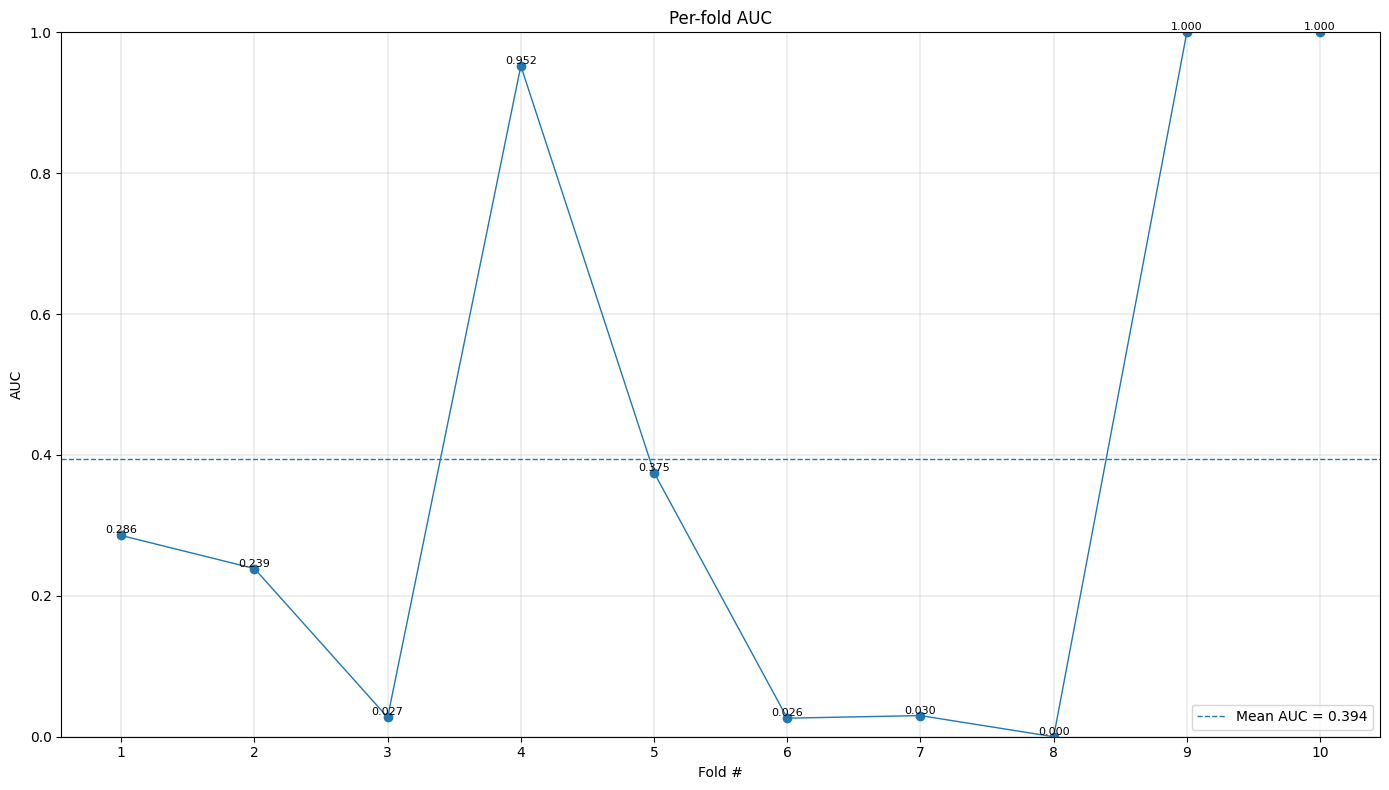

In [ ]:
# === Plot per-fold AUCs ===
import matplotlib.pyplot as plt
import numpy as np

fold_indices = np.arange(1, len(fold_aucs) + 1, dtype=int)
auc_array = np.array(fold_aucs, dtype=float)

plt.figure(figsize=(14, 8))
# line+markers; NaNs will break the line, which is fine
plt.plot(fold_indices, auc_array, marker="o", linewidth=1)

# annotate non-NaN points with their values
for i, a in enumerate(auc_array, start=1):
    if not np.isnan(a):
        plt.text(i, a, f"{a:.3f}", ha="center", va="bottom", fontsize=8)

# draw mean AUC if available
valid_mask = ~np.isnan(auc_array)
if valid_mask.any():
    mean_auc = auc_array[valid_mask].mean()
    plt.axhline(mean_auc, linestyle="--", linewidth=1, label=f"Mean AUC = {mean_auc:.3f}")

plt.title("Per-fold AUC")
plt.xlabel("Fold #")
plt.ylabel("AUC")
plt.xticks(fold_indices)
plt.ylim(0.0, 1.0)
plt.grid(True, linewidth=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()